In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
from datetime import datetime, timedelta

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)
print("Columns", df.columns)
df.head()

Columns Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
series_x_field = 'Tpot (K)'
def extract_series():
  series = df[series_x_field]
  series.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
  series = series.groupby(pd.Grouper(freq='D')).mean()
  series = series.fillna(method='ffill')
  return series

series = extract_series()

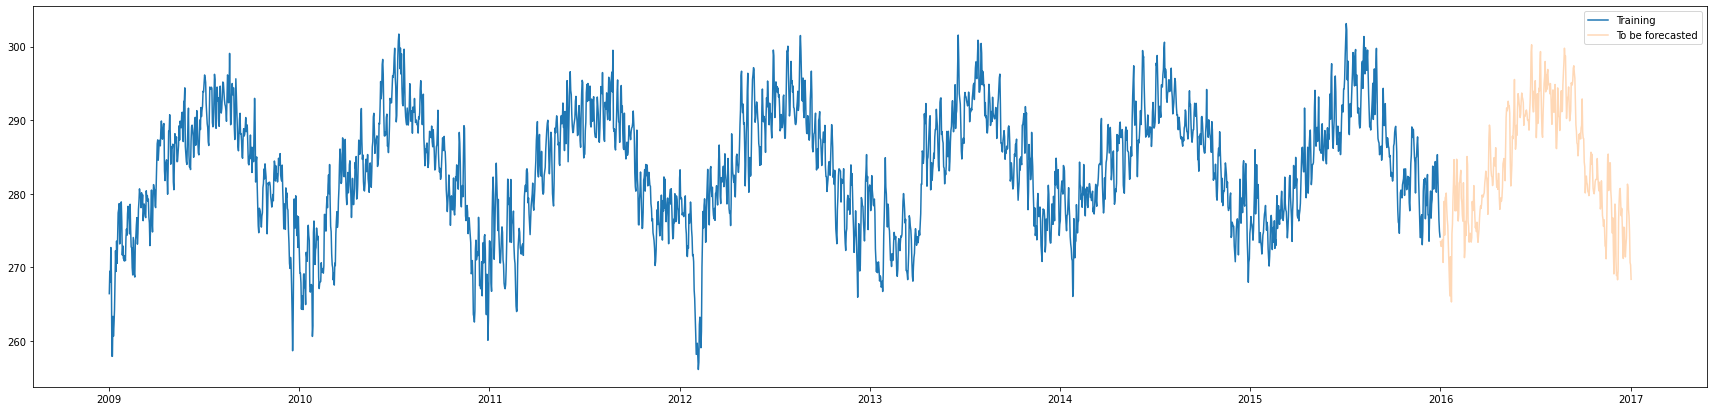

In [5]:
split_time = datetime(2016, 1, 1)
train_series = series[ series.index < split_time ]
val_series = series[ (series.index >= split_time) ]

plt.figure(figsize=(30,7))
plt.plot(train_series, label="Training")
plt.plot(val_series, label="To be forecasted", alpha=0.3)
plt.legend()
plt.show()


# Baseline - Naive Forecast

In [6]:
def compute_naive_forecast(series, split_time):
  forecast = series.shift(1)
  return forecast[ forecast.index >= split_time]

naive_forecast = compute_naive_forecast(series, split_time)
naive_forecast.shape
val_series.shape


(367,)

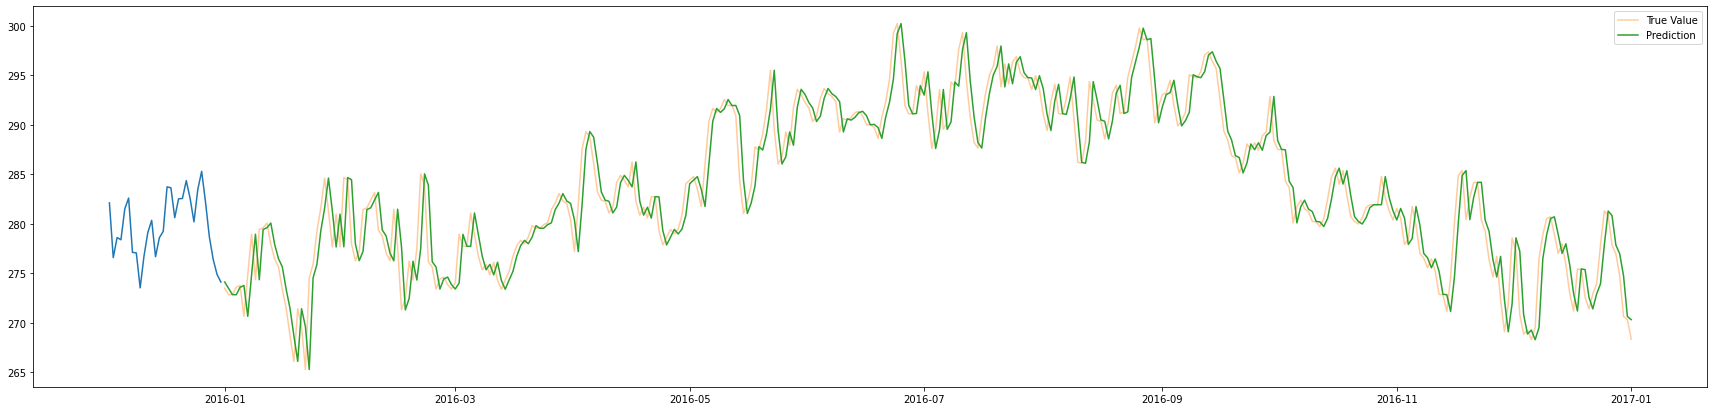

Mean Squared Error 6.310


In [7]:
naive_forecast.fillna(method='ffill', inplace=True)
naive_forecast[naive_forecast.isna()]

grace_period = (split_time - timedelta(days=30))

plt.figure(figsize=(30,7))
plt.plot(train_series[ train_series.index >= grace_period])
plt.plot(val_series, label="True Value", alpha=0.4)
plt.plot(naive_forecast, label="Prediction")
plt.legend()
plt.show()

mse = tf.keras.metrics.mse(val_series, naive_forecast).numpy()
print(f"Mean Squared Error {mse:.3f}")

# Using deep learning

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reshaped_series = np.reshape(series.values, (-1,1))
scaler.fit(reshaped_series)

# def normalize(series):
#   reshaped_series = np.reshape(series.values, (-1,1))
#   scaled_values = scaler.transform(reshaped_series)
#   scaled_values = scaled_values.squeeze()
#   scaled_values = pd.Series(scaled_values)
#   scaled_values.index = series.index

#   return scaled_values

def normalize(features,x):
  print(">>>>", len(features), x)

  return features,x



def windowize_dataset(series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(len(series)//4)
  # ds = ds.map(lambda w: (normalize(w[:-1]), w[-1]))
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  ds = ds.batch(32)
  ds = ds.map(normalize)


  return ds

# def normalize(previous, label):
#   print(">>>", previous)
#   # print(">>>", label)
#   print()
#   image = scaler.transform(previous)
#   return image, label

window_size = 5
batch_size = 32
# train_ds = windowize_dataset(train_series, window_size, batch_size)
val_ds = windowize_dataset(val_series, window_size)#.batch(batch_size).prefetch(1)

# print(type(val_ds))


# for i1, i2 in val_ds.take(1):
#   print(i1)
#   print()
#   print(i2)

>>>> Tensor("strided_slice:0", shape=(), dtype=int32) Tensor("args_1:0", shape=(None,), dtype=float64)


# Find optimal learning rate

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=(window_size,))
])

optimizer = tf.keras.optimizers.SGD(lr=1e-1, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=['mse', 'mae']
)

epochs = 100
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda _, lr: lr * 1.25)
history = model.fit(train_ds, 
                    epochs=epochs,
                    callbacks=[lr_scheduler])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


NameError: ignored

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'], label='Loss')
print("Reasonable learning rate: 1e-6")

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e6, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=['mse', 'mae']
)

epochs = 1000
stopper = tf.keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_ds, 
                    epochs=epochs,
                    validation_data = val_ds,
                    callbacks=[stopper])

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.show()

In [ ]:
def nn_forecast(series, window_size, batch_size):
  series = normalize(series)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)

  forecast = pd.Series(model.predict(ds)[:,0])
  forecast.index = series.index[window_size-1:]

  return forecast

forecast_features = series[ series.index > (split_time - timedelta(days=window_size))]
forecast = nn_forecast(forecast_features, window_size, batch_size)#[:,0]
forecast

In [ ]:
grace_period = (split_time - timedelta(days=30))

plt.figure(figsize=(30,7))
plt.plot(train_series)
# plt.plot(train_series[ train_series.index >= grace_period])
plt.plot(val_series, label="True Values", color='black', alpha=0.4)
plt.plot(forecast, label="To be forecasted", color='red')
plt.legend()
plt.show()

mse = tf.keras.metrics.mean_squared_error(val_series, forecast).numpy()
print(f"Neural Network MSE: {mse:.2f}")